# Week 1 — Session 1: Building a Histogram in Python
**Goal:** Getting familiar with jupyter notebook, pandas, seaborn, markdown, quarto:
- Loading the data and validating it.  
- First chart with matlibplot @fig-matlibplot   
- First chart with seaborn @fig-seaborn  
- Explore seaborn penguins dataset


In [55]:
import pandas as pd

cities = pd.DataFrame({
    "city": ["DC", "NY", "LA", "Chicago", "Houston"],
    "population": [712816, 8336817, 3898747, 2746388, 2304580]
})

cities.head()

,city,population
0,DC,712816
1,NY,8336817
2,LA,3898747
3,Chicago,2746388
4,Houston,2304580


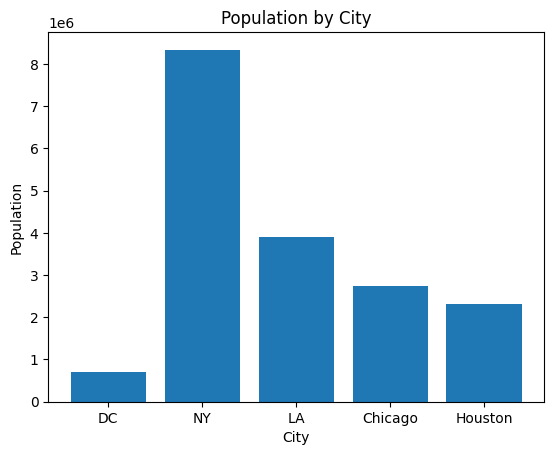

In [61]:
#| label: fig-matlibplot
#| fig-cap: "population bar chart with matlibplot"

import matplotlib.pyplot as plt
import seaborn as sns


# Matplotlib bar chart
plt.bar(cities["city"], cities["population"])
plt.title("Population by City")
plt.xlabel("City"); plt.ylabel("Population")
plt.show()

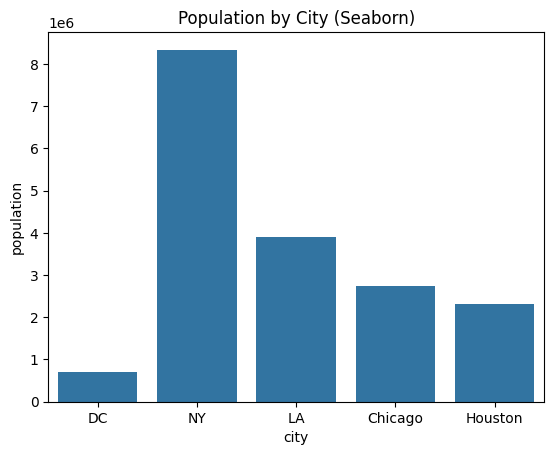

In [57]:
#| label: fig-seaborn
#| fig-cap: "population bar chart with seaborn"

# Seaborn bar chart
sns.barplot(data=cities, x="city", y="population")
plt.title("Population by City (Seaborn)")
plt.show()

In [58]:
cities.describe(include="all")
print("Missing values by column:\n", cities.isna().sum())

Missing values by column:
 city          0
population    0
dtype: int64


[Text(0.5, 1.0, 'Penguins: Flipper vs Body Mass'),
 Text(0.5, 0, 'Flipper length (mm)'),
 Text(0, 0.5, 'Body mass (g)')]

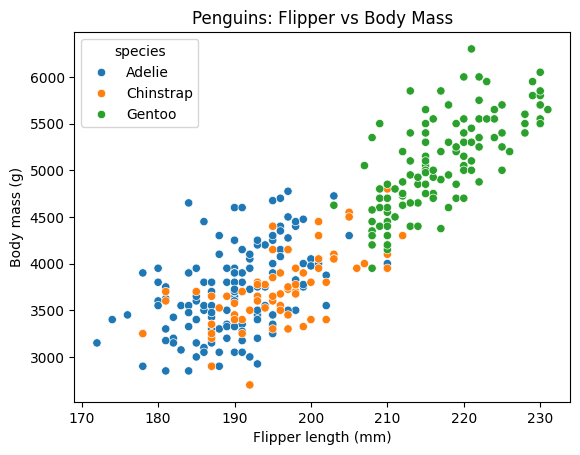

In [59]:
penguins = sns.load_dataset("penguins").dropna()
ax = sns.scatterplot(data=penguins, x="flipper_length_mm", y="body_mass_g", hue="species")
ax.set(title="Penguins: Flipper vs Body Mass", xlabel="Flipper length (mm)", ylabel="Body mass (g)")


# Week 1 — Session 2: Building a Histogram in Python

**Goal:** Replicate the spirit of the D3 unemployment histogram ([Observable reference](https://observablehq.com/@d3/histogram/2)) using Python, step by step.

We'll start from a single-column CSV of values (uploaded as `unemployment-x.csv`) and cover:  
- Loading the data and validating it.  
- Choosing a sensible binning strategy (Freedman–Diaconis and fixed-bin alternatives).  
- Computing histogram counts and edges with NumPy.  
- Plotting the histogram with Matplotlib (counts and density versions).  
- Documenting assumptions and labeling the chart.  



## Learning Objectives
- Understand how a histogram is constructed from raw numeric values.
- Apply the **Freedman–Diaconis** rule to choose bin widths.
- Use `numpy.histogram` and `numpy.histogram_bin_edges` to get counts and bin edges.
- Create publication-ready histograms in Matplotlib (one chart per cell).


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)


Python: 3.12.11
pandas: 2.3.2
numpy: 2.3.2
matplotlib: 3.10.5



## 1) Load & Inspect the Data
Place `unemployment-x.csv` in the **same folder** as this notebook (or a specific path).


In [20]:

df = pd.read_csv("unemployment-x.csv")

print("\nData preview:")
display(df.head())
print("\nInfo:")
print(df.info())
print(df.shape)



Data preview:


,id,state,county,rate
0,1001,Alabama,Autauga County,5.1
1,1003,Alabama,Baldwin County,4.9
2,1005,Alabama,Barbour County,8.6
3,1007,Alabama,Bibb County,6.2
4,1009,Alabama,Blount County,5.1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3219 entries, 0 to 3218
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3219 non-null   int64  
 1   state   3219 non-null   object 
 2   county  3219 non-null   object 
 3   rate    3219 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 100.7+ KB
None
(3219, 4)



### 1a) Select the numeric series
Pick the column(s) of interest for plotting


In [7]:
s = pd.to_numeric(df['rate'], errors="coerce").dropna()
print(f"Series length after dropping NaNs: {len(s)}")

# Basic sanity checks
print("Min/Max:", float(s.min()), float(s.max()))
print("Mean/Std:", float(s.mean()), float(s.std(ddof=1)))


Series length after dropping NaNs: 3219
Min/Max: 1.6 26.4
Mean/Std: 5.423330226778502 2.3881985261101404



## 2) Choose Bins: Freedman–Diaconis & Alternatives

A histogram groups values into bins. The **Freedman–Diaconis** rule suggests a bin width:
$h = 2 \cdot IQR \cdot n^{-1/3}$ ,
where *IQR* is the interquartile range and *n* is the sample size. The number of bins is roughly:
$\lceil (\max - \min) / h \rceil$

We'll compare:
- **Freedman–Diaconis** (`bins='fd'` in NumPy).
- A **fixed** number of bins (e.g., 20) similar to common defaults.
- (Optional) **Sturges** or **square-root** rules.


In [31]:

# Freedman–Diaconis bin edges via NumPy
edges_fd = np.histogram_bin_edges(s, bins='fd')
print("FD edges count:", len(edges_fd))

# Also compute the FD bin count via the formula for illustration
q75, q25 = np.percentile(s, [75, 25])
iqr = q75 - q25
n = s.size
h = 2 * iqr * (n ** (-1/3)) if iqr > 0 else None
if h is not None and h > 0:
    approx_bins = int(np.ceil((s.max() - s.min()) / h))
    print("FD approx. bin count (manual):", approx_bins, "| h =", h)
else:
    print("IQR=0 (or too small); FD rule degenerates. Falling back to 20 bins.")
    edges_fd = np.histogram_bin_edges(s, bins=20)

# Fixed bin edges (20 bins) for comparison
edges_20 = np.histogram_bin_edges(s, bins=20)
print("Fixed (20) edges count:", len(edges_20))


FD edges count: 85
FD approx. bin count (manual): 84 | h = 0.2979973149232311
Fixed (20) edges count: 21



## 3) Build the Histogram Arrays
NumPy returns **counts** and **edges**. The *i*-th bin is the interval `[edges[i], edges[i+1])`.


In [32]:

counts_fd, edges_fd_used = np.histogram(s, bins=edges_fd)
print("Counts (first 10):", counts_fd[:10])
print("Edges (first 10): ", edges_fd_used[:10])


Counts (first 10): [  9  31  42  71 107 151 183 183 215 241]
Edges (first 10):  [1.6        1.8952381  2.19047619 2.48571429 2.78095238 3.07619048
 3.37142857 3.66666667 3.96190476 4.25714286]



## 4) Plot the Histogram (Counts)
One chart per cell; we’ll label axes and give a descriptive title.


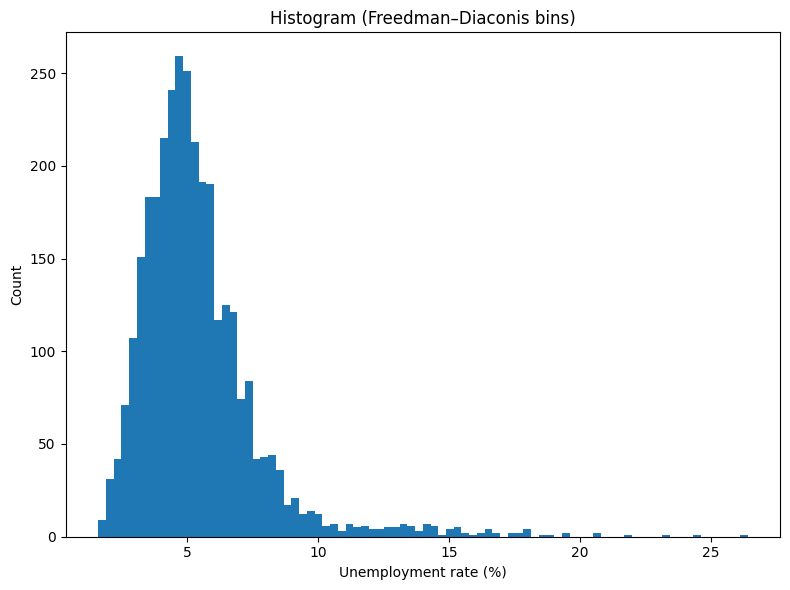

In [33]:

plt.figure(figsize=(8, 6))
plt.hist(s, bins=edges_fd_used)  # default is counts
plt.xlabel("Unemployment rate (%)")
plt.ylabel("Count")
plt.title("Histogram (Freedman–Diaconis bins)")
plt.tight_layout()
plt.show()



## 5) Plot the Histogram (Density)
Sometimes a **density** view (area=1) is more informative for comparing distributions of different sizes.


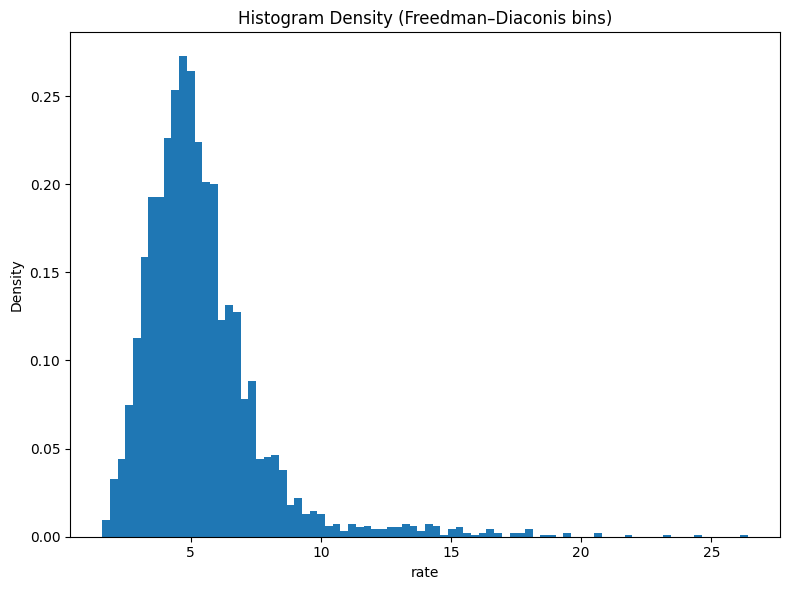

In [34]:

plt.figure(figsize=(8, 6))
plt.hist(s, bins=edges_fd_used, density=True)
plt.xlabel("rate")
plt.ylabel("Density")
plt.title("Histogram Density (Freedman–Diaconis bins)")
plt.tight_layout()
plt.show()



## 6) Compare with a Fixed Number of Bins (20)
A fixed number of bins is a common default and makes it easy to match external examples.


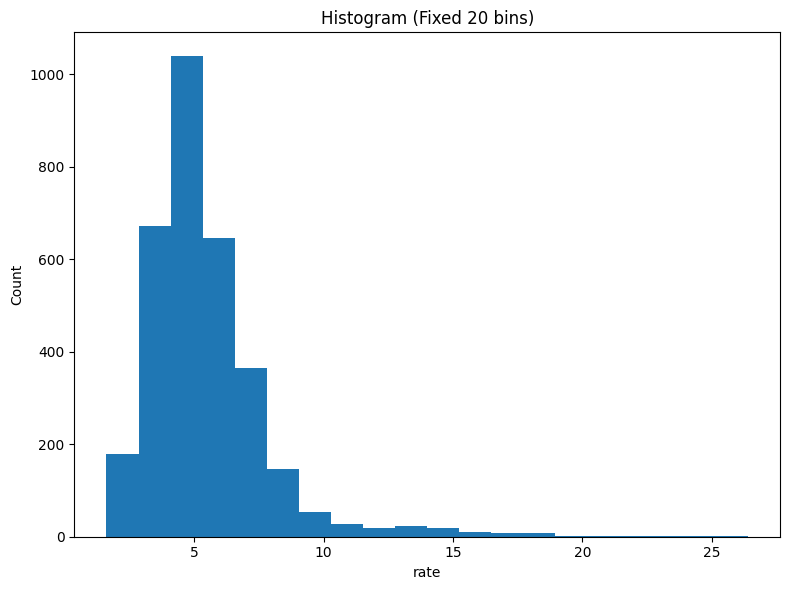

In [35]:

plt.figure(figsize=(8, 6))
plt.hist(s, bins=edges_20)  # counts with 20 fixed bins
plt.xlabel("rate")
plt.ylabel("Count")
plt.title("Histogram (Fixed 20 bins)")
plt.tight_layout()
plt.show()



## 7) Notes, Assumptions, and Next Steps
- If your data are percentages, label the x-axis accordingly (e.g., "Unemployment rate (%)").
- If the **IQR** is close to zero, the FD rule may produce too few or degenerate bins; consider fixed-bin or alternative rules.
- Use **consistent bin edges** when comparing multiple groups.
- For interactivity (like the D3 demo), consider plotting the same distribution with a widget to change the bin count (later weeks).
